In [11]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import os
import qkeras
import tensorflow as tf 
print(tf.__version__)
print(qkeras.__version__)
print(pd.__version__)
print(np.__version__)
from nn_globals import *
from nn_plotting import __generate_delta_plots__
from dataset import muon_data_split
from keras.models import Model
from nn_evaluate import huber_loss, k_fold_validation
from nn_pruning_module_support import loading_trained_model
from nn_training import train_model, lr_schedule
from keras.regularizers import L1L2
from tensorflow.keras.optimizers import Adam
from qkeras.qlayers import QDense, QActivation
from keras.layers import Input, BatchNormalization, Dense, Activation
from keras.callbacks import LearningRateScheduler, TerminateOnNaN, EarlyStopping, ModelCheckpoint
from nn_quantization_module_support import save_qmodel

2.6.0
0.9.0
1.3.4
1.19.5


In [12]:
# Import muon data
# 'x' is the array of input variables, 'y' is the q/pT
x_train_displ, x_test_displ, y_train_displ, y_test_displ, dxy_train_displ, dxy_test_displ= muon_data_split(filename=DATAFILEPATH, 
                                                                                                           reg_pt_scale=REG_PT_SCALE, 
                                                                                                           reg_dxy_scale=REG_DXY_SCALE, 
                                                                                                           test_size=TEST_SIZE,
                                                                                                           nvariables = NVARIABLES,
                                                                                                           nentries= NENTRIES,
                                                                                                         batch_size = 128)

[INFO    ] Loading muon data from ./data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)
[INFO    ] Loaded # of training and testing events: (2249964, 1034656)
[WARNING ] The last batch for training could be too few! (2024967%128)=7. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*0.9) % 128
[WARNING ] The last batch for training after mixing could be too few! (4049935%128)=15. Please change test_size.
[WARNING ] Try this formula: int(int(3284620*0.685)*2*0.9) % 128


In [13]:
def create_model_quantized_randomized(
                           bits, 
                           int_bits, 
                           nvariables, 
                           lr=0.001, 
                           clipnorm=10., 
                           initializer = "he_uniform",
                           nodes1=64, 
                           nodes2=32, 
                           nodes3=16, 
                           outnodes=2,
                           l1_reg = 0.0, 
                           l2_reg = 0.0,
                           quantization_type = "S"): # 'S' for symmetric, 'A' for asymmetric, 'H' for Hybrid
  
    # intializing the quantizers and layer variables
    if quantization_type == "S": 
        kernelQuantizer = "quantized_bits(bits={},integer={},symmetric = True,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits)
        activationQuantizer = "quantized_tanh(bits ={}, symmetric = False, use_stochastic_rounding=True, use_real_tanh =True)".format(bits)
    if quantization_type == "A":
        kernelQuantizer = "quantized_bits(bits={},integer={},symmetric = False,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits)
        activationQuantizer = "quantized_tanh(bits ={}, symmetric = False, use_stochastic_rounding=True, use_real_tanh =True)".format(bits)        
    else:
        firstLayerQuantizer = "quantized_bits(bits={},integer={},symmetric = False,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits)
        kernelQuantizer = "quantized_bits(bits={},integer={},symmetric = True,use_stochastic_rounding=True, qnoise_factor = 1.0, alpha = 1.0)".format(bits, int_bits)
        activationQuantizer = "quantized_tanh(bits ={}, symmetric = True, use_stochastic_rounding=True, use_real_tanh =True)".format(bits)
    
    regularizer = L1L2(l1=l1_reg, l2=l2_reg)
    bn_momentum = 0.9
    eps = 1e-4

    x = x_in = Input((nvariables,))
    x = BatchNormalization(epsilon=eps, momentum=bn_momentum,name="bn-input")(x)
    if quantization_type == "H":
        x = QDense(nodes1, 
                   kernel_quantizer = firstLayerQuantizer,
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-1")(x)
    else:
        x = QDense(nodes1, 
                   kernel_quantizer = kernelQuantizer,
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-1")(x)
    x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-1")(x)
    x = QActivation(activation = activationQuantizer,
                    name="act_1")(x)        
    
    if nodes2:
    
        x = QDense(nodes2, 
                   kernel_quantizer = kernelQuantizer, 
                   kernel_initializer=initializer,
                   use_bias = False,
                   kernel_regularizer = regularizer,
                   name="hidden-dense-2")(x)
        x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-2")(x)
        x = QActivation(activation = activationQuantizer,
                    name="act_2")(x)
        if nodes3:

            x = QDense(nodes3, 
                       kernel_quantizer = kernelQuantizer, 
                       kernel_initializer=initializer,
                       kernel_regularizer = regularizer,
                       use_bias = False,
                       name="hidden-dense-3")(x)
            x = BatchNormalization(epsilon = eps, momentum  = bn_momentum, name = "bn-3")(x)
            x = QActivation(activation = activationQuantizer, 
                            name="act_3")(x)

    x = QDense(outnodes,
                kernel_quantizer = kernelQuantizer,
                kernel_initializer = initializer,
                use_bias = True,
                name="dense-output")(x)
    x = Activation("linear")(x)
    
    model = Model(inputs=x_in, outputs=x,name="quantized-model")
    
    adam = Adam(lr=lr, clipnorm=clipnorm)
    model.compile(optimizer=adam, 
                  loss=huber_loss, 
                  metrics=['acc','mse','mae'])

    model.summary()
    return model
    

In [24]:
bits = 8
ints = 4
normal_epochs = 300
normal_batch_size = 1000
l1_reg = 0.0
l2_reg = 0.0
learning_rate = 0.01
gradient_clip_norm = 100.
initializer = "he_uniform"

# callbacks
lr_decay = LearningRateScheduler(lr_schedule)
terminate_on_nan = TerminateOnNaN()
model_training_checkpoint = ModelCheckpoint(monitor="val_loss", 
                                           verbose = 1,
                                           filepath = "checkpoints/half_baseline_qkeras_model_ckpt_epoch_{epoch:02d}.hdf5",
                                           period = 10)
early_stopping = EarlyStopping(monitor = "val_loss", 
                                               min_delta= 1e-5, 
                                               mode = "auto", 
                                               patience = 10)

qmodel = create_model_quantized_randomized(
                                            bits = bits,
                                            int_bits = ints,
                                            nvariables = NVARIABLES, 
                                            lr = learning_rate, 
                                            clipnorm = gradient_clip_norm, 
                                            nodes1=10, 
                                            nodes2=7, 
                                            nodes3=5, 
                                            outnodes=2,
                                            initializer = initializer,
                                            l1_reg = l1_reg, 
                                            l2_reg = l2_reg,
                                            quantization_type= "H",
                                           )

logger.info('Training model with l1_reg: {0} l2_reg: {1}'.format(l1_reg, l2_reg))

qmodel, history = train_model(qmodel, 
                      x_train_displ, 
                      np.column_stack((y_train_displ, dxy_train_displ)),
                      save_model=False, 
                      epochs=normal_epochs, 
                      batch_size=normal_batch_size,
                      callbacks=[lr_decay,
                                 terminate_on_nan,
                                 early_stopping,
                                 model_training_checkpoint],
                      validation_split=0.1, 
                      verbose=True)

metrics = [len(history.history['loss']), history.history['loss'][-1], history.history['val_loss'][-1]]
logger.info('Epoch {0}/{0} - loss: {1} - val_loss: {2}'.format(*metrics))

/Users/gpradhan/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(
[INFO    ] Training model with l1_reg: 0.0 l2_reg: 0.0
[INFO    ] Begin training ...


Model: "quantized-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 23)]              0         
_________________________________________________________________
bn-input (BatchNormalization (None, 23)                92        
_________________________________________________________________
hidden-dense-1 (QDense)      (None, 10)                230       
_________________________________________________________________
bn-1 (BatchNormalization)    (None, 10)                40        
_________________________________________________________________
act_1 (QActivation)          (None, 10)                0         
_________________________________________________________________
hidden-dense-2 (QDense)      (None, 7)                 70        
_________________________________________________________________
bn-2 (BatchNormalization)    (None, 7)             

2022-01-25 12:50:23.796429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2025/2025 [==============================] - ETA: 0s - loss: 23.6766 - acc: 0.9083 - mse: 816.6082 - mae: 18.2559

2022-01-25 12:51:05.452789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


2025/2025 [==============================] - 44s 21ms/step - loss: 23.6766 - acc: 0.9083 - mse: 816.6082 - mae: 18.2559 - val_loss: 14.2461 - val_acc: 0.9285 - val_mse: 283.6509 - val_mae: 11.2382
Epoch 2/300
2025/2025 [==============================] - 44s 22ms/step - loss: 13.9518 - acc: 0.9314 - mse: 272.2433 - mae: 11.0193 - val_loss: 13.9974 - val_acc: 0.9324 - val_mse: 270.3017 - val_mae: 11.0539
Epoch 3/300
2025/2025 [==============================] - 43s 21ms/step - loss: 13.7979 - acc: 0.9323 - mse: 267.1061 - mae: 10.9046 - val_loss: 14.0683 - val_acc: 0.9324 - val_mse: 271.5674 - val_mae: 11.1070
Epoch 4/300
2025/2025 [==============================] - 43s 21ms/step - loss: 13.7458 - acc: 0.9331 - mse: 265.3680 - mae: 10.8657 - val_loss: 13.8403 - val_acc: 0.9306 - val_mse: 265.1716 - val_mae: 10.9365
Epoch 5/300
2025/2025 [==============================] - 44s 21ms/step - loss: 13.6974 - acc: 0.9335 - mse: 263.9570 - mae: 10.8296 - val_loss: 13.6571 - val_acc: 0.9339 - val_

Epoch 39/300
2025/2025 [==============================] - 39s 19ms/step - loss: 13.3651 - acc: 0.9363 - mse: 256.0726 - mae: 10.5811 - val_loss: 13.3143 - val_acc: 0.9377 - val_mse: 254.3619 - val_mae: 10.5439
Epoch 40/300
2025/2025 [==============================] - 39s 19ms/step - loss: 13.3724 - acc: 0.9363 - mse: 256.1028 - mae: 10.5866 - val_loss: 13.2511 - val_acc: 0.9342 - val_mse: 252.9682 - val_mae: 10.4968

Epoch 00040: saving model to checkpoints/half_baseline_qkeras_model_ckpt_epoch_40.hdf5
Epoch 41/300
2025/2025 [==============================] - 39s 19ms/step - loss: 13.3620 - acc: 0.9365 - mse: 255.7989 - mae: 10.5789 - val_loss: 13.1993 - val_acc: 0.9374 - val_mse: 252.1240 - val_mae: 10.4574
Epoch 42/300
2025/2025 [==============================] - 39s 19ms/step - loss: 13.3610 - acc: 0.9364 - mse: 255.8390 - mae: 10.5780 - val_loss: 13.1918 - val_acc: 0.9374 - val_mse: 251.9076 - val_mae: 10.4513
Epoch 43/300
2025/2025 [==============================] - 39s 19ms/step 

[INFO    ] Done training. Time elapsed: 0:48:16.791156 sec
[INFO    ] Epoch 71/71 - loss: 13.325237274169922 - val_loss: 13.180363655090332


MAE as obtained on test dataset:


2022-01-25 13:38:40.511152: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean MAE for 1-Fold cv for momentum = 11.898110461150754
Mean MAE for 1-Fold cv for displacement = 15.077595419973372
RMSE as obtained on test dataset:
Mean RMSE for 1-Fold cv for momentum = 53.076260369729205
Mean RMSE for 1-Fold cv for displacement = 20.96973398173652


[INFO    ] # of entries: 1034656, mean: -0.009821201972725511, std: 0.19710201715910622
[INFO    ] gaus fit (a, mu, sig): [ 4.04989102e+04 -3.42760722e-02  3.72050567e-01]


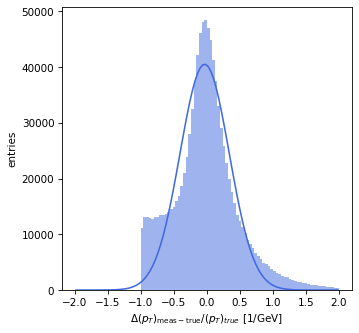

[INFO    ] # of entries: 150277, mean: 0.6733098249446812, std: 18.077474674094457
[INFO    ] gaus fit (a, mu, sig): [7.07438028e+03 1.10755367e+00 6.56046901e+00]


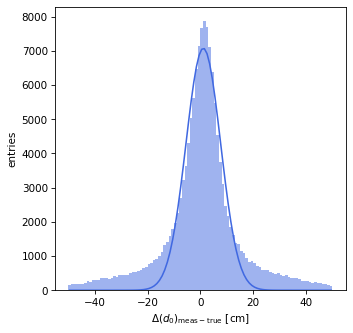

In [25]:
print("MAE as obtained on test dataset:")
k_fold_validation(model = qmodel, 
                  x = x_test_displ,  
                  y = y_test_displ, 
                  dxy = dxy_test_displ, 
                  folds = 1,
                  metric_type="MAE")

print("RMSE as obtained on test dataset:")
k_fold_validation(model = qmodel, 
                  x = x_test_displ,  
                  y = y_test_displ, 
                  dxy = dxy_test_displ, 
                  folds = 1,
                  metric_type = "RMSE")

# Evaluate the quantized resolution
__generate_delta_plots__(model = qmodel,
                        x = x_test_displ,
                        y = y_test_displ,
                        dxy = dxy_test_displ,
                        color = "royalblue"
                        )

[INFO    ] Loading muon data from ./data/NN_input_params_FlatXYZ.npz ...
[INFO    ] Loaded the variables with shape (19300000, 25)
[INFO    ] Loaded the parameters with shape (19300000, 6)
[INFO    ] Loaded the encoded variables with shape (3284620, 23)
[INFO    ] Loaded the encoded parameters with shape (3284620,)


MAE as obtained on test dataset:
Mean MAE for 1-Fold cv for momentum = 11.853701374703526
Mean MAE for 1-Fold cv for displacement = 15.080823597133405
RMSE as obtained on test dataset:
Mean RMSE for 1-Fold cv for momentum = 52.735201061524315
Mean RMSE for 1-Fold cv for displacement = 20.972331972817113


[INFO    ] # of entries: 3284620, mean: -0.009986643383910202, std: 0.19710398089442827
[INFO    ] gaus fit (a, mu, sig): [ 1.28517403e+05 -3.46619237e-02  3.72303730e-01]


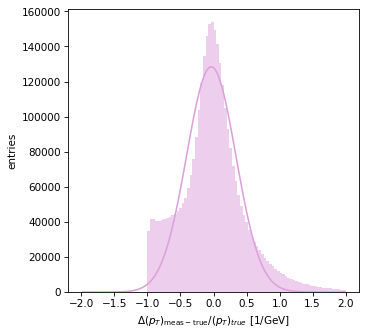

[INFO    ] # of entries: 477217, mean: 0.608287727727623, std: 18.10723787708365
[INFO    ] gaus fit (a, mu, sig): [2.24288433e+04 1.09788946e+00 6.57199147e+00]


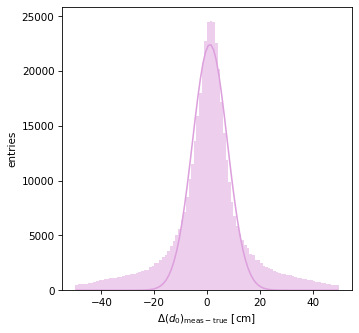

In [26]:
x, y, dxy = muon_data_split(filename=DATAFILEPATH, 
                           reg_pt_scale=REG_PT_SCALE, 
                           reg_dxy_scale=REG_DXY_SCALE, 
                           test_size=0,
                           nvariables = NVARIABLES,
                           nentries= NENTRIES,
                           batch_size = 1)

print("MAE as obtained on test dataset:")
k_fold_validation(model = qmodel, 
                  x = x,  
                  y = y, 
                  dxy = dxy, 
                  folds = 1,
                  metric_type="MAE")

print("RMSE as obtained on test dataset:")
k_fold_validation(model = qmodel, 
                  x = x,  
                  y = y, 
                  dxy = dxy, 
                  folds = 1,
                  metric_type = "RMSE")

# Evaluate the quantized resolution
__generate_delta_plots__(model = qmodel,
                        x = x,
                        y = y,
                        dxy = dxy,
                        color = "plum"
                        )

In [27]:
from nn_quantization_module_support import save_qmodel
save_qmodel( model_for_export = qmodel ,
            bits = 8 ,
            int_bits = 4,
            sparsity = 0 ,
            l1_reg_val = 0.0 ,
            l2_reg_val = 0.0 ,
            epochs = normal_epochs,
            batch_size = normal_batch_size,
            quantization_type = "H" ,
            additional_prefix = "HALF" )

... quantizing model
  bn-input has not been quantized
  bn-1 has not been quantized
  bn-2 has not been quantized
  bn-3 has not been quantized
